## Ejercicio 1

In [1]:
# Simulando las series
set.seed(123)

# Tamaño de muestra
n <- 100

# Y1t: serie con estacionalidad
Y1t <- ts(sin(2 * pi * (1:n) / 12) + rnorm(n), frequency = 12)

# Y2t: serie estacionaria
Y2t <- arima.sim(list(order = c(1, 0, 1), ar = 0.5, ma = -0.3), n = n)

# Y3t: serie con cambio estructural
Y3t <- c(rnorm(n/2, mean = 5), rnorm(n/2, mean = 10))

# Y4t: serie integrada de orden 1
Y4t <- cumsum(rnorm(n))

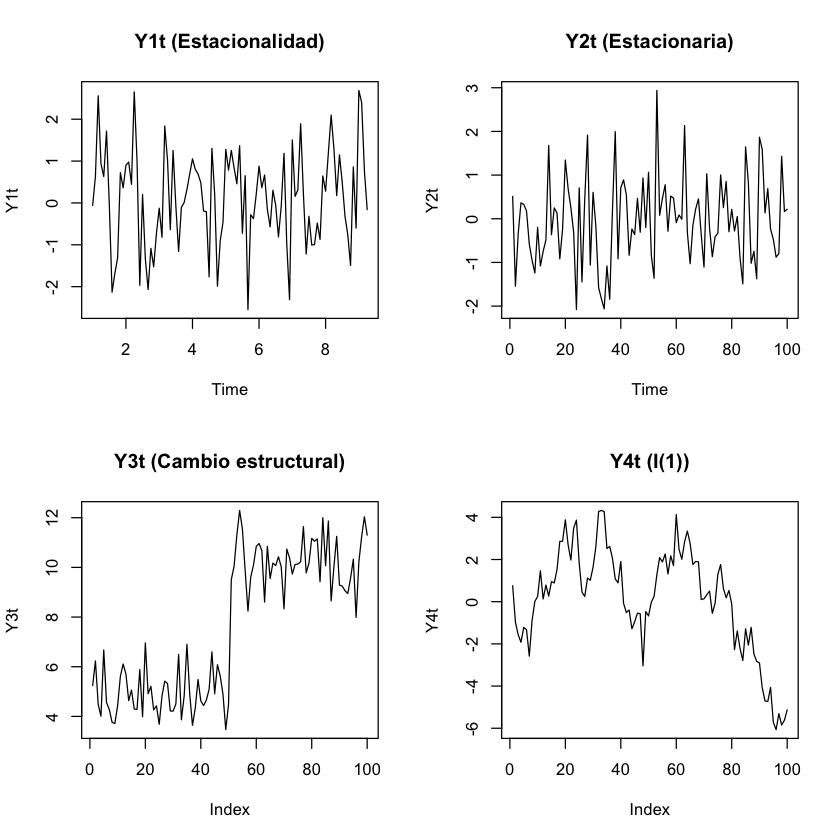

In [2]:
# Ploteando las series
par(mfrow = c(2, 2))
plot(Y1t, main = "Y1t (Estacionalidad)", type = "l")
plot(Y2t, main = "Y2t (Estacionaria)", type = "l")
plot(Y3t, main = "Y3t (Cambio estructural)", type = "l")
plot(Y4t, main = "Y4t (I(1))", type = "l")

Para poder estimar un modelo VAR, las series $Y_{1t}, Y_{2t}, Y_{3t} \text{ y } Y_{4t}$ deben ser estacionarias.
Graficamente parece ser que $Y_{1t}$ es estacionaria, para verficar esto, aplicamos la prueba de Dickey-Fuller Aumentada (ADF).

In [3]:
library(tseries)

# Aplicar ADF a las series originales
adf_Y1t <- adf.test(Y1t)  # Serie con estacionalidad

adf_Y1t

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Warning message in adf.test(Y1t):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  Y1t
Dickey-Fuller = -6.1764, Lag order = 4, p-value = 0.01
alternative hypothesis: stationary


Podemos ver que el p-valor es menor a 0.05 cuando aplicamos ADF a la serie $Y_{1t}$, por lo que rechazamos la hipotesis nula y concluimos que es estacionaria.

In [4]:
# Aplicamos una diferenciación a las series
Y3t_diff <- diff(Y3t)
Y4t_diff <- diff(Y4t)

# Realizamos la prueba ADF
adf_Y3t <- adf.test(Y3t_diff)  # Para Y3t diferenciada
adf_Y4t <- adf.test(Y4t_diff)  # Para Y4t diferenciada

adf_Y3t
adf_Y4t

Warning message in adf.test(Y3t_diff):
“p-value smaller than printed p-value”
Warning message in adf.test(Y4t_diff):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  Y3t_diff
Dickey-Fuller = -5.708, Lag order = 4, p-value = 0.01
alternative hypothesis: stationary



	Augmented Dickey-Fuller Test

data:  Y4t_diff
Dickey-Fuller = -4.2066, Lag order = 4, p-value = 0.01
alternative hypothesis: stationary


Dado que el p-valor es menor a 0.05 en cada prueba, rechazamos la hipotesis nula y concluimos que las series $Y_{3t} \text{ y } Y_{4t}$ son estacionarias

Procedemos ahora a obtener el número de rezagos optimo, para ajustar el modelo VAR

In [5]:
# Asegúramos de que todas las series tengan la misma longitud
min_length <- min(length(Y1t), length(Y2t), length(Y3t_diff), length(Y4t_diff))

Y1t <- Y1t[(length(Y1t) - min_length + 1):length(Y1t)]
Y2t <- Y2t[(length(Y2t) - min_length + 1):length(Y2t)]
Y3t_diff <- Y3t_diff[(length(Y3t_diff) - min_length + 1):length(Y3t_diff)]
Y4t_diff <- Y4t_diff[(length(Y4t_diff) - min_length + 1):length(Y4t_diff)]

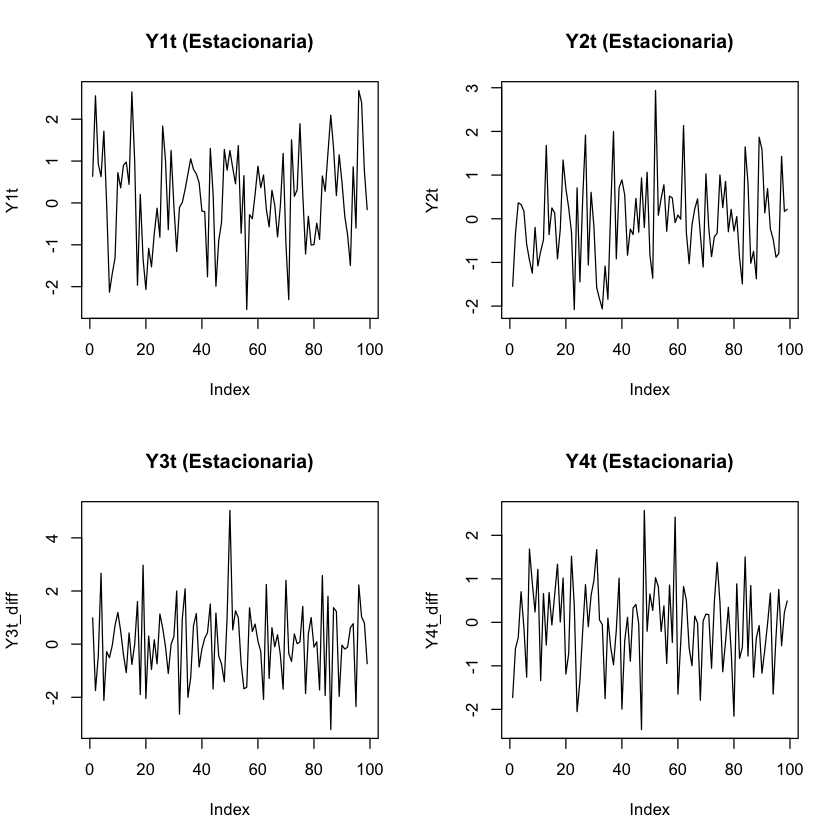

In [6]:
# Ploteando las series
par(mfrow = c(2, 2))
plot(Y1t, main = "Y1t (Estacionaria)", type = "l")
plot(Y2t, main = "Y2t (Estacionaria)", type = "l")
plot(Y3t_diff, main = "Y3t (Estacionaria)", type = "l")
plot(Y4t_diff, main = "Y4t (Estacionaria)", type = "l")

In [7]:
# Combinar las series
series_combinadas <- cbind(Y1t, Y2t, Y3t_diff, Y4t_diff)

In [8]:
library(vars)

# Determinamos el número óptimo de rezagos
lag_selection <- VARselect(series_combinadas, lag.max = 8)
print(lag_selection$selection)  # Vemos la recomendación basada en AIC, SC, HQ

Cargando paquete requerido: MASS

Cargando paquete requerido: strucchange

Cargando paquete requerido: zoo


Adjuntando el paquete: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Cargando paquete requerido: sandwich

Cargando paquete requerido: urca

Cargando paquete requerido: lmtest



AIC(n)  HQ(n)  SC(n) FPE(n) 
     1      1      1      1 


Esto nos indica que el modelo optimo es con un rezago en las series de tiempo, por lo que procedemos a ajustar el modelo VAR con un rezago

In [9]:
var_model <- VAR(series_combinadas, p = 1, type = "none")
summary(var_model)  # Para obtener un resumen del modelo


VAR Estimation Results:
Endogenous variables: Y1t, Y2t, Y3t_diff, Y4t_diff 
Deterministic variables: none 
Sample size: 98 
Log Likelihood: -576.807 
Roots of the characteristic polynomial:
0.3788 0.2256 0.2256 0.1311
Call:
VAR(y = series_combinadas, p = 1, type = "none")


Estimation results for equation Y1t: 
Y1t = Y1t.l1 + Y2t.l1 + Y3t_diff.l1 + Y4t_diff.l1 

            Estimate Std. Error t value Pr(>|t|)   
Y1t.l1       0.32153    0.09657   3.330  0.00124 **
Y2t.l1      -0.23358    0.11259  -2.075  0.04076 * 
Y3t_diff.l1  0.03646    0.07884   0.463  0.64478   
Y4t_diff.l1 -0.05683    0.11018  -0.516  0.60722   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Residual standard error: 1.086 on 94 degrees of freedom
Multiple R-Squared: 0.135,	Adjusted R-squared: 0.09817 
F-statistic: 3.667 on 4 and 94 DF,  p-value: 0.008056 


Estimation results for equation Y2t: 
Y2t = Y1t.l1 + Y2t.l1 + Y3t_diff.l1 + Y4t_diff.l1 

            Estimate Std. Error t value Pr(>|t

Podemos observar que las raices del polinomio caracteristico del modelo VAR son menores a 1, por lo que estan dentro del circulo unitario e indica que el modelo es estable.
También observamos que $Y_{1t}$ y $Y_{3t}$ son significativas para sus respectivas ecuaciones.

In [10]:
normality_test <- normality.test(var_model)

# Imprimir los resultados de las pruebas
print(normality_test)

$JB

	JB-Test (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 11.985, df = 8, p-value = 0.1519


$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 6.0373, df = 4, p-value = 0.1964


$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 5.9481, df = 4, p-value = 0.2031




$jb.mul
$jb.mul$JB

	JB-Test (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 11.985, df = 8, p-value = 0.1519


$jb.mul$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 6.0373, df = 4, p-value = 0.1964


$jb.mul$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 5.9481, df = 4, p-value = 0.2031




Realizando la prueba de normalidad, obtenemos lo siguiente:

Para JB-Test: El p-valor es igual a 0.1519, por lo que no se rechaza la hipótesis de que el modelo sigue una distribución normal multivariada.

Skewness (Asimetría): El p-valor es igual a 0.1964, por lo que no hay evidencia suficiente para que se concluya que los residuos presentan una simetria significativa.

Kurtosis: El p-valor es igual a 0.2031, por lo que no se rechazar la hipótesis de que los residuos tienen una curtosis normal.

Por lo tanto, los resultados sugieren que no hay evidencia significativa para rechazar la normalidad de los residuos del modelo VAR.

In [11]:
serial_test <- serial.test(var_model)

# Imprimir los resultados de las pruebas
print(serial_test)


	Portmanteau Test (asymptotic)

data:  Residuals of VAR object var_model
Chi-squared = 210.57, df = 240, p-value = 0.9149



$serial

	Portmanteau Test (asymptotic)

data:  Residuals of VAR object var_model
Chi-squared = 210.57, df = 240, p-value = 0.9149



Obtenemos que el p-valor es igual a 0.9149, por lo que no se rechaza la hipotesis nula de que no existe autocorrelación en los residuos del modelo VAR.

In [12]:
arch_test <- arch.test(var_model)

# Imprimir los resultados de las pruebas
print(arch_test)


	ARCH (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 539.02, df = 500, p-value = 0.1104



$arch.mul

	ARCH (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 539.02, df = 500, p-value = 0.1104



Obtenemos que el p-valor es igual a 0.1104, por lo que no se puede rechazar la hipótesis nula de que no hay presencia de heterocedasticidad condicional.

In [13]:
# Causalidad de Granger
causality(var_model, cause = "Y1t")  # Probamos si Y1t causa a otras variables

$Granger

	Granger causality H0: Y1t do not Granger-cause Y2t Y3t_diff Y4t_diff

data:  VAR object var_model
F-Test = 1.813, df1 = 3, df2 = 376, p-value = 0.1443


$Instant

	H0: No instantaneous causality between: Y1t and Y2t Y3t_diff Y4t_diff

data:  VAR object var_model
Chi-squared = 0.99435, df = 3, p-value = 0.8026



Obtenemos que el p-valor es igual a 0.1443, por lo que no se puede rechazar la hipótesis nula. Lo que nos sugiere que no hay suficiente evidencia para concluir que $Y_{1t}$ causa a las otras variables en el modelo.

In [14]:
# Causalidad de Granger
causality(var_model, cause = "Y3t_diff")  # Probamos si Y3t causa a otras variable

$Granger

	Granger causality H0: Y3t_diff do not Granger-cause Y1t Y2t Y4t_diff

data:  VAR object var_model
F-Test = 0.38953, df1 = 3, df2 = 376, p-value = 0.7606


$Instant

	H0: No instantaneous causality between: Y3t_diff and Y1t Y2t Y4t_diff

data:  VAR object var_model
Chi-squared = 2.2367, df = 3, p-value = 0.5248



Obtenemos que el p-valor es igual a 0.5248, por lo que no se puede rechazar la hipótesis nula. Lo que nos sugiere que no hay suficiente evidencia para concluir que $Y_{3t}$ causa a las otras variables en el modelo

## Ejercicio 2

In [148]:
# Función para generar valores propios
generar_eigenvalores <- function(K, level = 'leve') {
    if (level == 'leve') {
        return(runif(K, 0.6, 0.9999))
    } else if (level == 'moderada') {
        return(runif(K, 0.3, 0.5999))
    } else {
        return(runif(K, 0, 0.2999))
    }
}

In [60]:
# Función para generar una matriz Ai
generar_matriz_Ai <- function(K, nivel = 'leve'){

    eigenvalores <- generar_eigenvalores(K, nivel)
    # Generamos matriz ortogonal B usando la descomposición QR
    B <- qr.Q(qr(matrix(rnorm(K * K), K, K)))
    # Creamos matriz diagonal con los valores propios
    D <- diag(eigenvalores)
    # Construimos la matriz A_i = B D B^{-1}
    A_i <- B %*% D %*% solve(B)
    
    return(A_i)
}

In [61]:
# Función para verificar la estabilidad de una matriz
verificar_estabilidad <- function(A_i) {
    # Calculamos los valores propios de la matriz A_i
    eigenvalores <- eigen(A_i)$values
    
    # Verificamos si el módulo de todos los valores propios es menor que 1
    estables <- all(Mod(eigenvalores) < 1)
    
    return(estables)
}

In [145]:
# Sin establecer una semilla fija para hacerlo aleatorio en cada ejecución
set.seed(as.numeric(format(Sys.time(), "%S")))

K <- 3  # Dimensión de cada matriz A_i
p <- 2  # Orden del VAR(p)

# Lista para almacenar las A_i matrices
matrices_Ai <- list()
niveles <- c("leve", "moderada", "fuerte")

A_1 <- generar_matriz_Ai(K, nivel = 'leve')
matrices_Ai[[1]] <- A_1

for (i in 2:(p)){
    # Seleccionamos un nivel de estabilidad aleatorio
    nivel_aleatorio <- sample(niveles, 1)

    # Generar matriz A_i con el nivel seleccionado
    A_i <- generar_matriz_Ai(K, nivel_aleatorio)

    # Almacenamos la matriz en la lista
    matrices_Ai[[i]] <- A_i
}

# Lista para almacenar A_i^{-1} A_{i+1}
A <- list()

# El primer bloque es A_1
A[[1]] <- matrices_Ai[[1]]

for (i in 2:p) {
    A[[i]] <- solve(matrices_Ai[[i-1]]) %*% matrices_Ai[[i]]
}

In [147]:
# Verificamos la estabilidad de cada matriz A[[i]]
estabilidad_matrices <- sapply(A, verificar_estabilidad)

# Verificamos si alguna matriz es inestable
if (any(estabilidad_matrices == FALSE)) {
    cat("La matriz es inestable.\n")
    } else {
    cat("La matriz es estable.\n")
}

La matriz es estable.


## Ejercicio 3

In [21]:
p_max <- function(K,T) {
    set.seed(as.numeric(format(Sys.time(), "%S")))

    alpha <- 0.05 # Nivel de significancia
    
    series_tiempo <- lapply(1:K, function(i) {
        ts(rnorm(T))  # Simular una serie de tiempo de T observaciones
    })

    # Calculamos la ACF para cada serie individualmente
    acf_valores <- lapply(series_tiempo, function(serie) {
        acf(serie, plot = FALSE)$acf
    })

    # Calculamos el nivel de confianza
    nivel_confianza <- qnorm(1 - alpha / 2) / sqrt(T)

    # Obtenemos el rezago donde la ACF sale del intervalo de confianza, para cada ACF de las series
    rezagos_maximos <- lapply(acf_valores, function(acf_vals) {
        # Seleccionamos los rezagos que estan dentro del intervalo de confianza 
        which(abs(acf_vals) > nivel_confianza) - 1
    })

    return(lapply(rezagos_maximos, max))
}

In [22]:
# Obtenemos los rezagos maximos de cada serie
K <- 1  # Número de series
T <- 200  # Número de observaciones

p_max(K,T)

[[1]]
[1] 0

In [23]:
# Obtenemos los rezagos maximos de cada serie
K <- 2  # Número de series
T <- 200  # Número de observaciones

p_max(K,T)

[[1]]
[1] 0

[[2]]
[1] 9

In [166]:
# Obtenemos los rezagos maximos de cada serie
K <- 5  # Número de series
T <- 200  # Número de observaciones

p_max(K,T)

[[1]]
[1] 1

[[2]]
[1] 11

[[3]]
[1] 10

[[4]]
[1] 18

[[5]]
[1] 3

Una vez obtenidos los rezagos maximos, podemos seleccionar el rezago que funcione bien para todas las series.

## Ejercicio 4

# 4. a)

In [25]:
path <- "./"

source(paste(path, "functions.r", sep = ""))

In [26]:
# Leemos el archivo de clima
clima_data <- read.csv("Clima_F.csv")

head(clima_data)
summary(clima_data)

library(seasonal)

# Convertimos las columnas de temperatura y precipitación en series de tiempo
ts_temp <- ts(clima_data$Temperatura, start=1985, frequency=12)  # Serie mensual de temperatura
ts_prec <- ts(clima_data$Precipitacion, start=1985, frequency=12)  # Serie mensual de precipitación


,Periodo,Temperatura,Precipitacion
,<chr>,<dbl>,<dbl>
1,ene-85,15.6,36.0
2,feb-85,17.1,16.5
3,mar-85,19.9,15.0
4,abr-85,21.0,37.2
5,may-85,23.1,51.5
6,jun-85,23.3,126.9


   Periodo           Temperatura    Precipitacion   
 Length:455         Min.   :14.80   Min.   :  5.90  
 Class :character   1st Qu.:18.55   1st Qu.: 18.35  
 Mode  :character   Median :22.00   Median : 39.10  
                    Mean   :21.35   Mean   : 65.07  
                    3rd Qu.:23.75   3rd Qu.:110.45  
                    Max.   :27.00   Max.   :244.20  

In [27]:
library(tseries)

# Verificamos que sean estacionarias
adf_temp = adf.test(ts_temp)
adf_temp

Warning message in adf.test(ts_temp):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  ts_temp
Dickey-Fuller = -16.871, Lag order = 7, p-value = 0.01
alternative hypothesis: stationary


In [28]:
adf_prec = adf.test(ts_prec)
adf_prec

Warning message in adf.test(ts_prec):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  ts_prec
Dickey-Fuller = -20.724, Lag order = 7, p-value = 0.01
alternative hypothesis: stationary


In [29]:
library(vars)

# Combinamos las series de temperatura y precipitación
data_var <- cbind(ts_temp, ts_prec)

# Determinar el número óptimo de rezagos (lags) para el modelo VAR
lag_selection <- VARselect(data_var, lag.max = 15, type = "const")
lag_selection$selection  # Esto te sugiere el número óptimo de rezagos

AIC(n)  HQ(n)  SC(n) FPE(n) 
    14     12     12     14

In [30]:
# Ajustar el modelo VAR con el número óptimo de rezagos
var_model <- VAR(data_var, p = 10, type = "const")
summary(var_model)


VAR Estimation Results:
Endogenous variables: ts_temp, ts_prec 
Deterministic variables: const 
Sample size: 445 
Log Likelihood: -2412.122 
Roots of the characteristic polynomial:
0.9992 0.9992 0.9722 0.9722 0.9645 0.9078 0.881 0.881 0.8529 0.8529 0.8467 0.8467 0.8127 0.8127 0.7778 0.7778 0.7709 0.7709 0.6045 0.6045
Call:
VAR(y = data_var, p = 10, type = "const")


Estimation results for equation ts_temp: 
ts_temp = ts_temp.l1 + ts_prec.l1 + ts_temp.l2 + ts_prec.l2 + ts_temp.l3 + ts_prec.l3 + ts_temp.l4 + ts_prec.l4 + ts_temp.l5 + ts_prec.l5 + ts_temp.l6 + ts_prec.l6 + ts_temp.l7 + ts_prec.l7 + ts_temp.l8 + ts_prec.l8 + ts_temp.l9 + ts_prec.l9 + ts_temp.l10 + ts_prec.l10 + const 

              Estimate Std. Error t value Pr(>|t|)    
ts_temp.l1   7.395e-01  4.451e-02  16.614  < 2e-16 ***
ts_prec.l1   2.952e-03  1.448e-03   2.039  0.04203 *  
ts_temp.l2   3.077e-02  5.697e-02   0.540  0.58936    
ts_prec.l2   1.798e-03  1.506e-03   1.194  0.23310    
ts_temp.l3  -1.348e-01  5.755e-02

In [31]:
# Prueba de causalidad de Granger: ¿La temperatura causa la precipitación?
granger_temp_cause_prec <- causality(var_model, cause = "ts_temp")
print(granger_temp_cause_prec$Granger)


	Granger causality H0: ts_temp do not Granger-cause ts_prec

data:  VAR object var_model
F-Test = 17.295, df1 = 10, df2 = 848, p-value < 2.2e-16



Dado que p-valor es igual a 2.2e-16, lo que rechaza la hipotesis nula, por lo que la temperatura causa a la precipitación.

In [32]:
# Prueba de causalidad de Granger: ¿La precipitación causa la temperatura?
granger_prec_cause_temp <- causality(var_model, cause = "ts_prec")
print(granger_prec_cause_temp$Granger)


	Granger causality H0: ts_prec do not Granger-cause ts_temp

data:  VAR object var_model
F-Test = 7.2621, df1 = 10, df2 = 848, p-value = 4.425e-11



Dado que p-valor es igual a 4.425e-11, lo que rechaza la hipotesis nula, por lo que la precipitación causa a la temperatura.\

Por lo que podemos concluir que la temperatura y la precipitación son causales en el sentido de Granger.

# 4. b)

In [33]:
# Leemos el archivo de clima
econ_data <- read.csv("Datos.csv")

In [34]:
library(lubridate)

# Revisamos si hay valores faltantes y removerlos o imputar si es necesario
econ_data <- na.omit(econ_data)

econ_data$Fecha <- ymd(paste0(econ_data$Fecha, "/01"))


Adjuntando el paquete: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




In [35]:
# Vector de meses en español e inglés
meses_es <- c("ene", "feb", "mar", "abr", "may", "jun", "jul", "ago", "sep", "oct", "nov", "dic")
meses_en <- c("Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec")

for (i in seq_along(meses_es)) {
    clima_data$Periodo <- gsub(meses_es[i], meses_en[i], clima_data$Periodo)
}

# Convertir las fechas con los meses en inglés a objetos Date
clima_data$Periodo <- as.Date(paste0("01-", clima_data$Periodo), format = "%d-%b-%y")

In [36]:
# Realizar el inner join por las fechas
df_comb_data <- merge(econ_data, clima_data, by.x = "Fecha", by.y = "Periodo", all = FALSE)
head(df_comb_data)

,Fecha,Inflacion,IGAE,IPC,TC,Temperatura,Precipitacion
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1993-01-01,12.97732,60.40769,1653.22,3.1100,17.3,43.2
2,1993-02-01,13.08335,61.02252,1546.68,3.0989,17.9,15.3
3,1993-03-01,13.15959,63.94325,1771.71,3.1083,19.2,14.2
4,1993-04-01,13.23548,61.86598,1665.41,3.0955,21.4,15.8
5,1993-05-01,13.31114,63.61290,1612.99,3.1227,22.6,34.2
6,1993-06-01,13.38580,62.88259,1670.29,3.1213,23.7,133.4


In [37]:
series_list <- list()

for (columna in colnames(df_comb_data)) {
    if (columna != 'Fecha') {
        # Convertir la columna a serie temporal
        ts_data <- ts(df_comb_data[[columna]], start = c(1993, 1), frequency = 12)
        adf_ts_data <- adf.test(ts_data)
        
        lag <- 1
        
        # Diferenciar hasta que el p-valor sea menor o igual a 0.05
        while(adf_ts_data$p.value > 0.05) {
            ts_data <- diff(ts_data, lag)
            adf_ts_data <- adf.test(ts_data)
            lag <- lag + 1
        }
        
        # Almacenar la serie diferenciada en la lista
        series_list[[columna]] <- ts_data
    }
}

Warning message in adf.test(ts_data):
“p-value smaller than printed p-value”
Warning message in adf.test(ts_data):
“p-value smaller than printed p-value”
Warning message in adf.test(ts_data):
“p-value smaller than printed p-value”
Warning message in adf.test(ts_data):
“p-value smaller than printed p-value”
Warning message in adf.test(ts_data):
“p-value smaller than printed p-value”


In [38]:
combined_ts <- do.call(cbind, series_list)
#  combined_ts <- na.locf(combined_ts)
combined_ts <- na.omit(combined_ts)

In [39]:
any(is.na(combined_ts)) 

[1] FALSE

In [40]:
# Determinamos el número óptimo de rezagos para el modelo VAR
lag_selection <- VARselect(combined_ts, lag.max = 15, type = "const")
lag_selection$selection  # Esto te sugiere el número óptimo de rezagos

AIC(n)  HQ(n)  SC(n) FPE(n) 
    13      5      3     13

In [41]:
# Usando 3 rezagos
var_model <- VAR(combined_ts, p = 3, type = "const")

# Resumen del modelo
summary(var_model)


VAR Estimation Results:
Endogenous variables: Inflacion, IGAE, IPC, TC, Temperatura, Precipitacion 
Deterministic variables: const 
Sample size: 347 
Log Likelihood: -5737.126 
Roots of the characteristic polynomial:
0.9938 0.9819 0.9819 0.8521 0.8521 0.6594 0.6594 0.6429 0.6429 0.584 0.584 0.5752 0.5752 0.5555 0.5555 0.4762 0.4762 0.3603
Call:
VAR(y = combined_ts, p = 3, type = "const")


Estimation results for equation Inflacion: 
Inflacion = Inflacion.l1 + IGAE.l1 + IPC.l1 + TC.l1 + Temperatura.l1 + Precipitacion.l1 + Inflacion.l2 + IGAE.l2 + IPC.l2 + TC.l2 + Temperatura.l2 + Precipitacion.l2 + Inflacion.l3 + IGAE.l3 + IPC.l3 + TC.l3 + Temperatura.l3 + Precipitacion.l3 + const 

                   Estimate Std. Error t value Pr(>|t|)    
Inflacion.l1      4.485e-01  5.205e-02   8.618 2.92e-16 ***
IGAE.l1          -6.993e-03  4.714e-03  -1.483 0.138938    
IPC.l1            2.133e-05  1.000e-05   2.132 0.033757 *  
TC.l1             3.459e-02  3.470e-02   0.997 0.319607    
Temperat

In [42]:
# Realizamos la prueba de causalidad de Granger
causality(var_model, cause = "Temperatura")

$Granger

	Granger causality H0: Temperatura do not Granger-cause Inflacion IGAE
	IPC TC Precipitacion

data:  VAR object var_model
F-Test = 25.549, df1 = 15, df2 = 1968, p-value < 2.2e-16


$Instant

	H0: No instantaneous causality between: Temperatura and Inflacion IGAE
	IPC TC Precipitacion

data:  VAR object var_model
Chi-squared = 17.01, df = 5, p-value = 0.00448



In [43]:
# Realizamos la prueba de causalidad de Granger
causality(var_model, cause = "Precipitacion")

$Granger

	Granger causality H0: Precipitacion do not Granger-cause Inflacion IGAE
	IPC TC Temperatura

data:  VAR object var_model
F-Test = 13.069, df1 = 15, df2 = 1968, p-value < 2.2e-16


$Instant

	H0: No instantaneous causality between: Precipitacion and Inflacion
	IGAE IPC TC Temperatura

data:  VAR object var_model
Chi-squared = 34.471, df = 5, p-value = 1.918e-06



# 4.c)

In [44]:
# Dividimos nuestro conjunto de entrenamiento, quitando los ultimos 24 meses
n <- nrow(combined_ts)

train_data <- combined_ts[1:(n - 24), ]
test_data <- combined_ts[(n - 23):n, ]

In [45]:
# Ajustamos el modelo VAR
library(vars)
var_model <- VAR(train_data, p = 3, type = "const")

In [46]:
# Realizamos las predicciones
var_forecast <- predict(var_model, n.ahead = 24)
valores_pred_var <- var_forecast$fcst$Temperatura[, "fcst"]

In [47]:
# Procedemos a generar el modelo SARIMA
library(forecast)

# Ajustar el modelo SARIMA
sarima_model <- auto.arima(train_data[, "Temperatura"])
sarima_forecast <- forecast(sarima_model, h = 24)
valores_pred_sarima <- sarima_forecast$mean


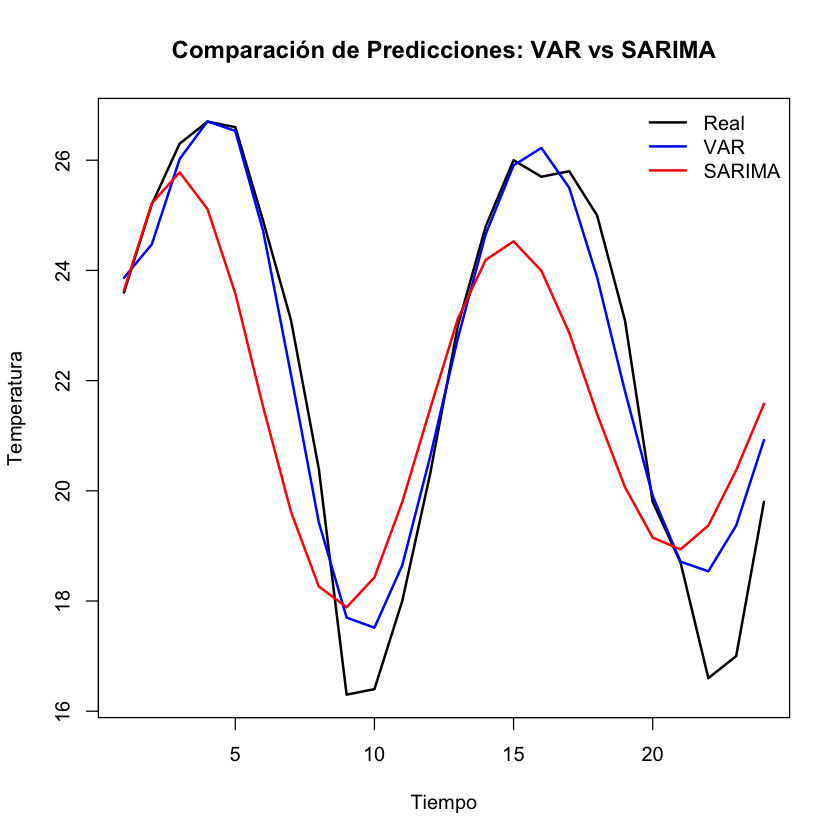

In [48]:
# Selecciona los últimos 24 meses de los valores reales de la temperatura
valores_reales <- test_data[, "Temperatura"]

# Crear un índice temporal para los valores reales y predicciones
time_index <- 1:24  # Usamos un índice del 1 al 24 ya que todas empiezan al mismo tiempo

# Establece el rango del eje Y para abarcar los valores reales y predicciones
y_range <- range(c(valores_reales, valores_pred_var, valores_pred_sarima))

# Graficar los valores reales de temperatura
plot(time_index, valores_reales, type = "l", col = "black", lwd = 2,
     ylim = y_range, xlab = "Tiempo", ylab = "Temperatura",
     main = "Comparación de Predicciones: VAR vs SARIMA")

# Añadir las predicciones del modelo VAR
lines(time_index, valores_pred_var, col = "blue", lwd = 2)

# Añadir las predicciones del modelo SARIMA
lines(time_index, valores_pred_sarima, col = "red", lwd = 2)

# Añadir la leyenda
legend("topright", legend = c("Real", "VAR", "SARIMA"),
     col = c("black", "blue", "red"), lwd = 2, bty = "n")


Por lo que podemos concluir que el modelo VAR(p) nos da una mejor predicción de los valores que el modelo SARIMA(p, d, q), pues los datos predichos se acercan más a los valores reales de la muestra.